In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas  1.1.4
seaborn 0.11.1
numpy   1.19.5



In [2]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [3]:
df_dag_train = pd.read_csv("../results/dag.prediction.train.response.updated.csv", sep="\t")
df_dag_train_warp = pd.read_csv("../results/dag.prediction.train.response.warp.updated.csv", sep="\t")
df_train = pd.read_csv("../data/train.txt", index_col=0, header = 0, sep="\t")
df_train_warp = pd.read_csv("../data/train.warp.txt", index_col=0, header = 0, sep="\t")
df_test = pd.read_csv("../data/test.txt", index_col=0, header = 0, sep="\t")
df_test_warp = pd.read_csv("../data/test.warp.txt", index_col=0, header = 0, sep="\t")

# df_train.columns = [col.replace(" ", "_").replace(";", ".") for col in df_train.columns]

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df_dag_train_warp[["day_plus_one" in _ for _ in df_dag_train_warp.columns]] = 0

df_dag_train_warp.loc[["food" in _ for _ in df_dag_train_warp.index], ["nutrients" in _ for _ in df_dag_train_warp.columns]] = 0
df_dag_train_warp.loc[[_.startswith("tax") for _ in df_dag_train_warp.index], ["kegg" in _ for _ in df_dag_train_warp.columns]] = 0


df_dag_train_warp.to_csv("../results/dag.prediction.train.response.warp.directed.txt", sep="\t")

df_dag_train[["day_plus_one" in _ for _ in df_dag_train.columns]] = 0

df_dag_train.loc[["food" in _ for _ in df_dag_train.index], ["nutrients" in _ for _ in df_dag_train.columns]] = 0
df_dag_train.loc[[_.startswith("tax") for _ in df_dag_train.index], ["kegg" in _ for _ in df_dag_train.columns]] = 0


df_dag_train.to_csv("../results/dag.prediction.train.response.directed.txt", sep="\t")

In [5]:
df_test_warp.shape

(108, 234)

In [6]:
df_test.shape

(108, 232)

In [7]:
# for feature in(features > 0).index:
#     if feature not in df_train.columns:
#         print(feature)

In [8]:
# day_plus_one = [col for col in data.loc[data.sum(axis=0) > 5,].columns if "Age" in col]
# name = day_plus_one[0]
# name = "day_plus_one.tax.k__Bacteria.p__Firmicutes_A.c__Clostridia.o__Oscillospirales.f__Ruminococcaceae.g__Faecalibacterium.s__Faecalibacterium_prausnitzii"
# v = data.loc[:,name]
# v2 = data.loc[:,name]
# print(v.loc[v > 0])
# print(v2.loc[v2 > 0])
day_plus_one = [col for col in df_dag_train.columns if "day_plus_one" in col]

In [9]:
s_binary = {"Gender", "Supplement"}

In [10]:
# food_and_nutrients = [col for col in df_dag_train.columns if "food" in col or "nutrient" in col]
# df_dag_train_food = df_dag_train.loc[food_and_nutrients, :]
# df_dag_train_food.loc[df_dag_train_food.sum(axis=1) > 0, df_dag_train_food.sum(axis=0) > 0]

In [11]:
# linear_models
d_response_2_model = {}
for response in day_plus_one:
    features = df_dag_train[response]
    significant_features = features[features > 0]
    if significant_features.sum() > 0:
        model_str = "Q('" + response + "')" + " ~ " + " + ".join(["Q('" + _ + "')"  if _ not in s_binary else "C(Q('" + _ + "'))" for _ in significant_features.index]) + " + 1"
        model = smf.ols(formula=model_str, data=df_train)
        res = model.fit_regularized(method="elastic_net", L1_wt=0)
#         res = model.fit()
        d_response_2_model[response] = res
        
# linear_models no food
d_response_2_model_no_food = {}
for response in day_plus_one:
    features = df_dag_train[response]
    significant_features = features[features > 0]
    significant_features = significant_features[[not (("nutrient" in _) or ("food" in _)) for _ in significant_features.index]]
    if significant_features.sum() > 0:
        model_str = "Q('" + response + "')" + " ~ " + " + ".join(["Q('" + _ + "')"  if _ not in s_binary else "C(Q('" + _ + "'))" for _ in significant_features.index]) + " + 1"
#         print(model_str)
        model = smf.ols(formula=model_str, data=df_train)
        res = model.fit_regularized(method="elastic_net", L1_wt=0)
#         res = model.fit()
        d_response_2_model_no_food[response] = res
        
# linear models warp
d_response_2_model_warp = {}
for response in day_plus_one:
    features = df_dag_train_warp[response]
    significant_features = features[features > 0]
    if significant_features.sum() > 0:
        model_str = "Q('" + response + "')" + " ~ " + " + ".join(["Q('" + _ + "')"  if _ not in s_binary else "C(Q('" + _ + "'))" for _ in significant_features.index]) + " + 1"
        model = smf.ols(formula=model_str, data=df_train_warp)
        res = model.fit_regularized(method="elastic_net", L1_wt=0)
        d_response_2_model_warp[response] = res
        
# linear_models no food
d_response_2_model_no_food_warp = {}
for response in day_plus_one:
    features = df_dag_train_warp[response]
    significant_features = features[features > 0]
    significant_features = significant_features[[not (("nutrient" in _) or ("food" in _)) for _ in significant_features.index]]
    if significant_features.sum() > 0:
        model_str = "Q('" + response + "')" + " ~ " + " + ".join(["Q('" + _ + "')"  if _ not in s_binary else "C(Q('" + _ + "'))" for _ in significant_features.index]) + " + 1"
        model = smf.ols(formula=model_str, data=df_train_warp)
        res = model.fit_regularized(method="elastic_net", L1_wt=0)
        d_response_2_model_no_food_warp[response] = res

In [12]:
# df_test_users = df_test.groupby("UserName").first()
d_results_basic = {}
for response in day_plus_one:
    if response in d_response_2_model:
        d_results_basic[response] = d_response_2_model[response].predict(df_test)
    else:
        print("here")
        d_results_basic[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results_basic = pd.DataFrame(d_results_basic)

# mse = (df_test[df_results.columns] - df_results).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse = (df_test[df_results_basic.columns] - df_results_basic).values.flatten()


# no food
d_results_no_food = {}
for response in day_plus_one:
    if response in d_response_2_model_no_food:
        d_results_no_food[response] = d_response_2_model_no_food[response].predict(df_test)
    else:
        print("here")
        d_results_no_food[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results_no_food = pd.DataFrame(d_results_no_food)

# mse_no_food = (df_test[df_results_no_food.columns] - df_results_no_food).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse_no_food = (df_test[df_results_no_food.columns] - df_results_no_food).values.flatten()


# warp
d_results_warp = {}
for response in day_plus_one:
    if response in d_response_2_model_warp:
        d_results_warp[response] = d_response_2_model_warp[response].predict(df_test_warp)
    else:
        d_results_warp[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results_warp = pd.DataFrame(d_results_warp)

# mse_warp = (df_test[df_results_warp.columns] - df_results_warp).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse_warp = (df_test_warp[df_results_warp.columns] - df_results_warp).values.flatten()

# no food warp
d_results_warp_no_food = {}
for response in day_plus_one:
    if response in d_response_2_model_no_food_warp:
        d_results_warp_no_food[response] = d_response_2_model_no_food_warp[response].predict(df_test_warp)
    else:
        d_results_warp_no_food[response] = df_test_warp[response.replace("day_plus_one.", "")]
    
df_results_warp_no_food = pd.DataFrame(d_results_warp_no_food)

# mse_warp_no_food = (df_test[df_results_no_food.columns] - df_results_warp_no_food).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse_warp_no_food = (df_test_warp[df_results_warp_no_food.columns] - df_results_warp_no_food).values.flatten()

# baseline
d_results_baseline = {}
for response in day_plus_one:
    d_results_baseline[response] = df_test[response.replace("day_plus_one.", "")]
    
df_results_baseline = pd.DataFrame(d_results_baseline)

# mse_baseline = (df_test[df_results.columns] - df_results_baseline).apply(lambda x: np.median(np.power(x, 2)), axis=0).median()
mse_baseline = (df_test[df_results_baseline.columns] - df_results_baseline).values.flatten()

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
df_results = pd.DataFrame([mse, mse_warp, mse_baseline, mse_no_food, mse_warp_no_food], index=["DBN", "DBN Warp", "Baseline", "DBN (no food)", "DBN Warp (no food)"]).T
# df_results = np.power(df_results, 2)
df_results = np.abs(df_results)
# df_results = df_results[["DBN", "DBN Warp", "Baseline"]]
# df_results = df_results[z<3]
df_results_tall = df_results.melt(value_vars=["DBN", "DBN Warp", "Baseline"])

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
mse_warp_no_food.max()

19.114186149802702

In [42]:
# import scipy.stats as stats

# data = df_results["Baseline"].values

# z = np.abs(stats.zscore(data))

# #only keep rows in dataframe with all z-scores less than absolute value of 3 
# data_clean = data[z<3]

In [32]:
# df_results = pd.DataFrame([mse, mse_warp, mse_baseline, mse_warp_no_food, mse_no_food], index=["mse", "mse_warp", "mse_baseline", "mse_warp_no_food", "mse_no_food"]).T
# df_results = np.sqrt(np.power(df_results, 2))
# df_results_tall = df_results.melt(value_vars=["mse", "mse_warp", "mse_baseline", "mse_warp_no_food", "mse_no_food"])

In [75]:
df_results.max()

DBN                   21.237261
DBN Warp              21.474293
Baseline              24.180702
DBN (no food)         21.237261
DBN Warp (no food)    21.474293
dtype: float64

In [76]:
df_results.median(axis=0)

DBN                   1.807301
DBN Warp              1.551211
Baseline              0.904997
DBN (no food)         1.779315
DBN Warp (no food)    1.522403
dtype: float64

In [77]:
df_results.mean(axis=0)

DBN                   3.115382
DBN Warp              2.802380
Baseline              2.810504
DBN (no food)         3.082356
DBN Warp (no food)    2.779800
dtype: float64

In [78]:
# perform Tukey's test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df_results_tall['value'],
                          groups=df_results_tall['variable'],
                          alpha=0.05)

In [79]:
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Baseline,DBN,0.3049,0.001,0.1422,0.4675,True
Baseline,DBN Warp,-0.0081,0.9,-0.1708,0.1545,False
DBN,DBN Warp,-0.313,0.001,-0.4757,-0.1503,True


In [80]:
df_results_tall

,variable,value
0,DBN,1.452506
1,DBN,2.539126
2,DBN,2.512565
3,DBN,3.349637
4,DBN,0.056239
...,...,...
15871,Baseline,10.265672
15872,Baseline,1.663469
15873,Baseline,2.737598
15874,Baseline,1.609449


/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


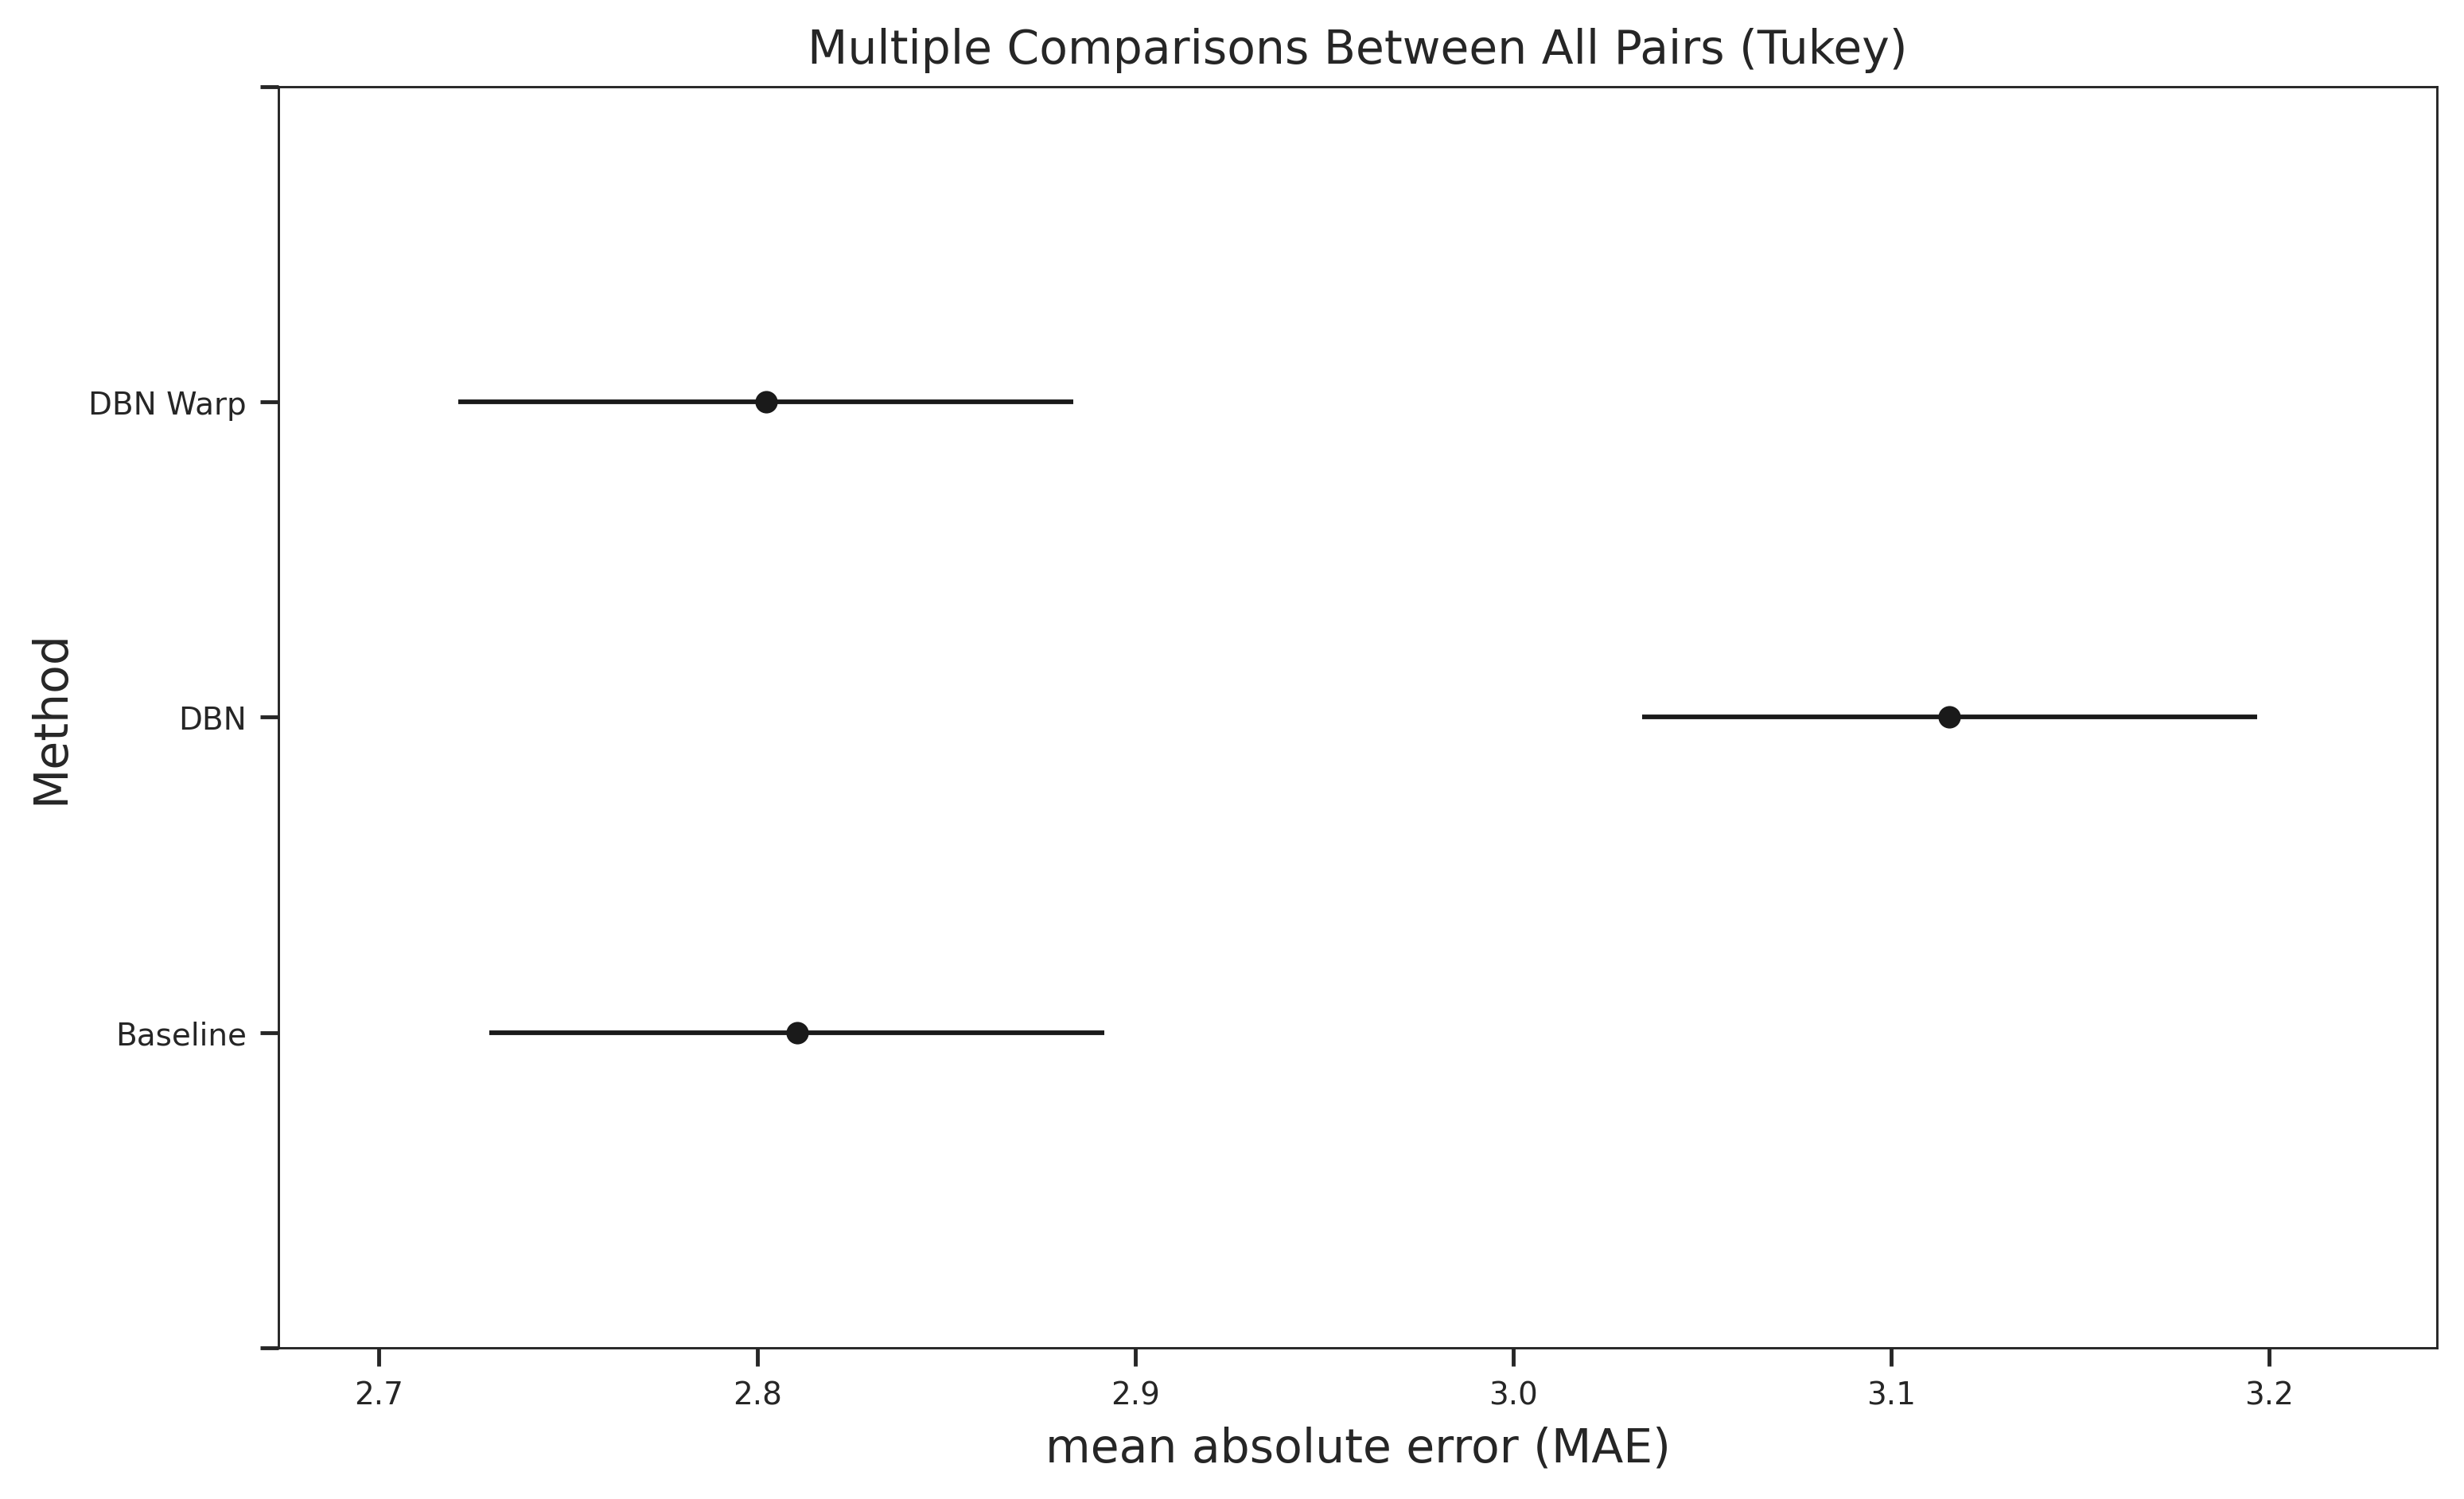

In [81]:
import plot_utils as pu
pu.figure_setup()
figsize = pu.get_fig_size(6.5 / 2)

fig, ax = plt.subplots(figsize=figsize)
# sns.boxplot(x="variable", y="value", data=df_results_tall, showfliers = False)
tukey.plot_simultaneous(ax=ax, xlabel="mean absolute error (MAE)", ylabel="Method")
pu.save_plot(fig, "tukey.box.plot")

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


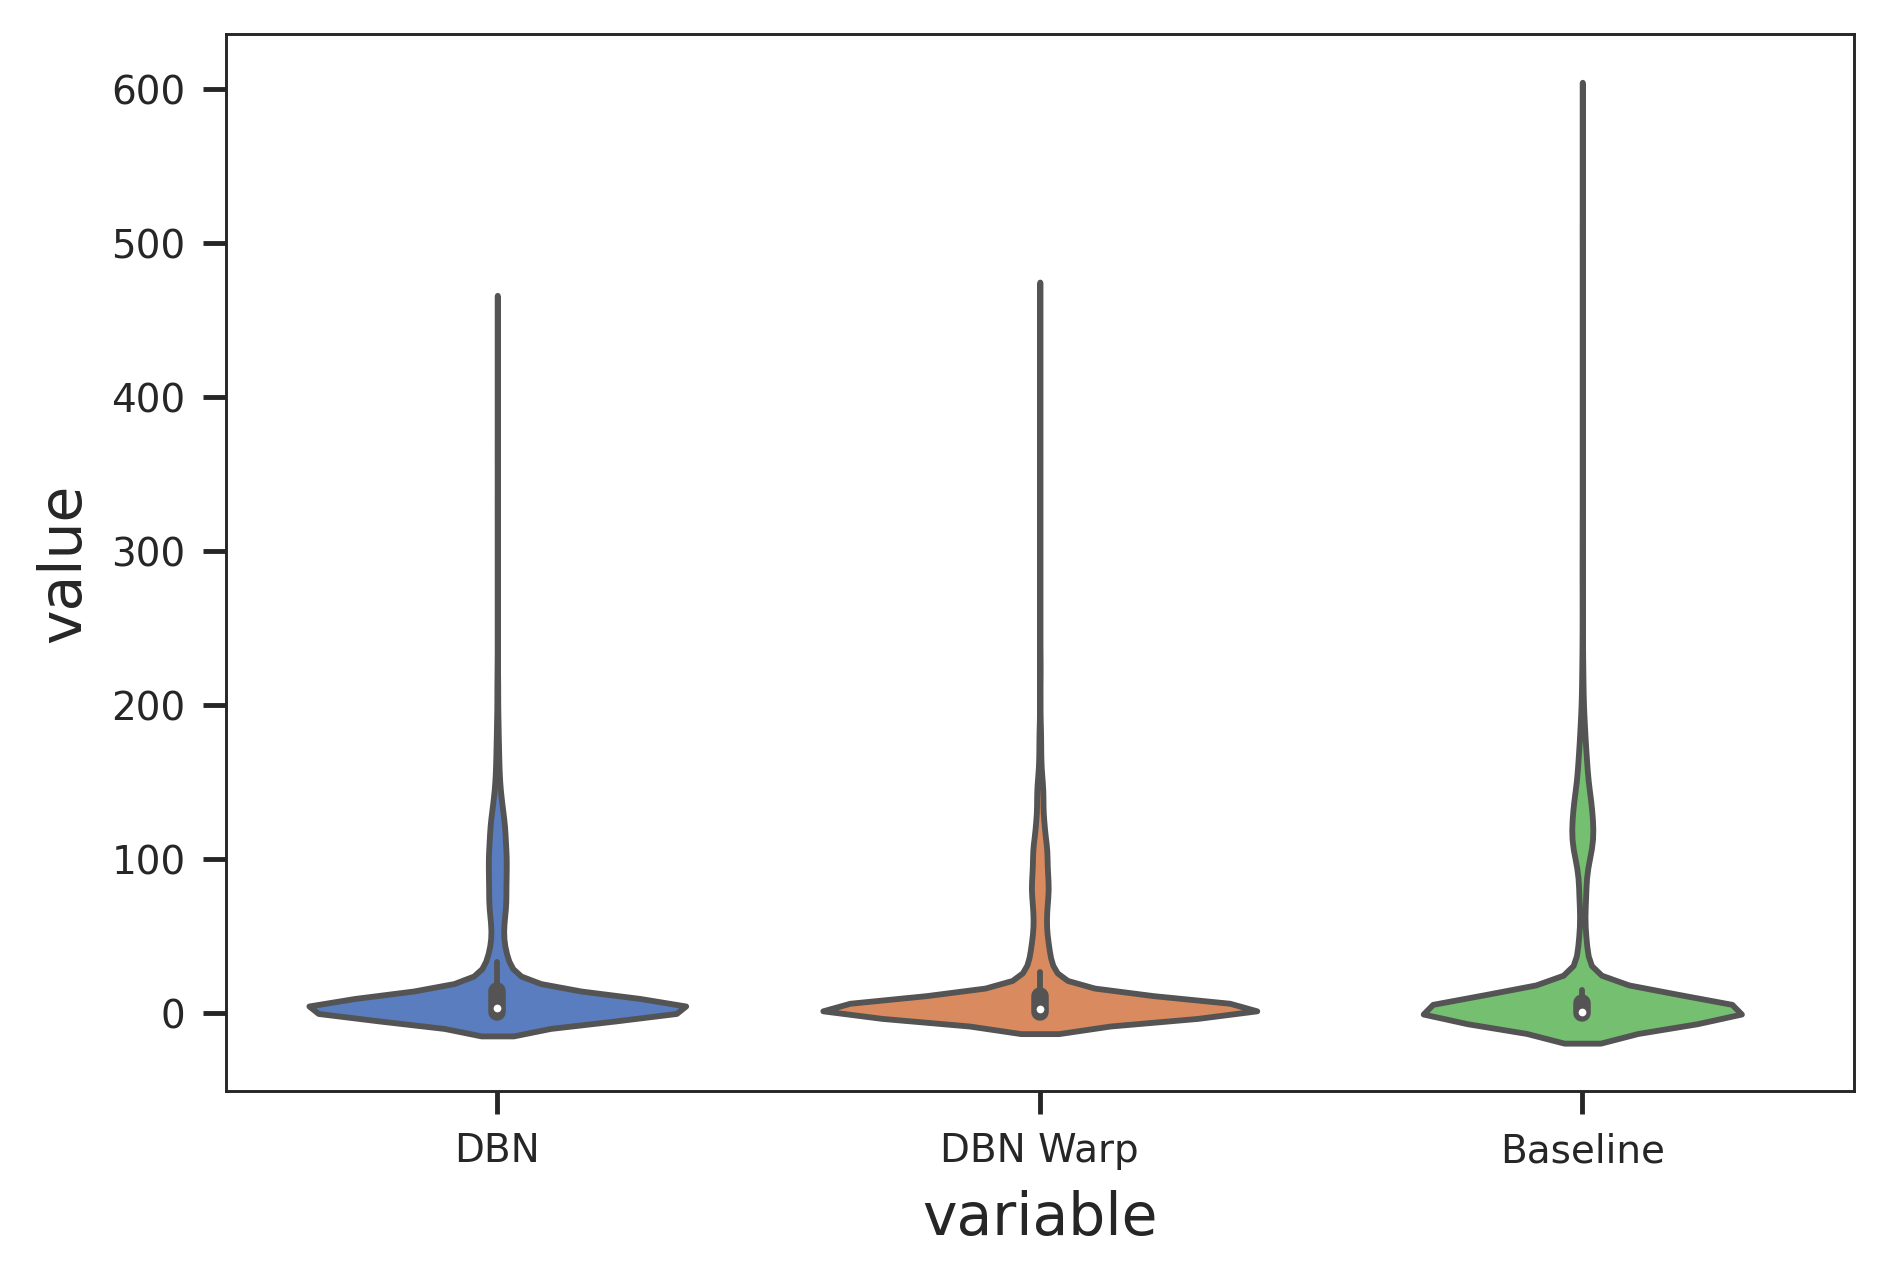

In [24]:
ax = sns.violinplot(x="variable", y="value", data=df_results_tall, palette="muted", kind="boxen")

In [25]:
# print(mse, mse_warp, mse_baseline, mse_warp_no_food, mse_no_food)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
df_train.shape

(361, 231)

In [27]:
# res.predict(df_test)